# Weather Forecasting Project


Our group has been diligently working on a weather prediction project utilizing data from [insert name]. Our primary objective was to forecast the 'solar_MW' feature, leveraging a model trained on data spanning from 2020 to 2023. This project, undertaken as part of our academic curriculum, has provided us with invaluable opportunities to enhance our skills in data science and data visualization. Through rigorous analysis and modeling, we aimed to utilize historical weather patterns to develop a predictive model. 

## Librairies

In order to run this notebook several libraries will be used. 
Download the several librairies by running in your terminal "pip install -r requirements.txt"

In [2]:
# For loading the dataset
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

# For the preprocessing
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

# For the models
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm

# For the score's predictions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# For plotting the dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# For the dashboard
from dash import Dash, html, dcc, Input, Output, callback
import plotly.graph_objects as go
    

In [3]:
def imputationKNN(df):
    """
    :param Dataframe df: a pandas dataset with nan values
    :returs: an imputated dataset
    """
    from sklearn.impute import KNNImputer
    dataImputed = KNNImputer(missing_values=np.nan,n_neighbors=3).fit_transform(df)
    dataImputed = pd.DataFrame(dataImputed, columns=df.columns)
    return dataImputed

## Data Cleaning



Firstly, we will create a dataset with all the features from the different csv and nc files.
Here is the data from the Energy's csv file which compile data from 2020 to 2023.

In [4]:
dataRaw = pd.read_csv("Energy_Data_20200920_20231027.csv")
dataRaw

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20T00:00:00Z,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20T00:30:00Z,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17
2,2020-09-20T01:00:00Z,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
3,2020-09-20T01:30:00Z,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00
4,2020-09-20T02:00:00Z,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
...,...,...,...,...,...,...,...,...,...
54379,2023-10-27T21:30:00Z,NaN,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47
54380,2023-10-27T22:00:00Z,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
54381,2023-10-27T22:30:00Z,NaN,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31
54382,2023-10-27T23:00:00Z,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


Then, we load the nc file containing the cloud cover, solar downward radiation and temperature features from the same period.

In [5]:
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar

<xarray.Dataset> Size: 133MB
Dimensions:                 (ref_datetime: 4467, valid_datetime: 93, point: 20)
Coordinates:
    latitude                (point) float64 160B ...
    longitude               (point) float64 160B ...
  * point                   (point) int64 160B 0 1 2 3 4 5 ... 14 15 16 17 18 19
  * ref_datetime            (ref_datetime) datetime64[ns] 36kB 2020-09-20 ......
  * valid_datetime          (valid_datetime) int64 744B 0 1 2 3 ... 114 117 120
Data variables:
    CloudCover              (ref_datetime, valid_datetime, point) float32 33MB ...
    SolarDownwardRadiation  (ref_datetime, valid_datetime, point) float64 66MB ...
    Temperature             (ref_datetime, valid_datetime, point) float32 33MB ...

We retrieve the 3 features and merge it into a single dataframe.

In [6]:
dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_featuresInter = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd_solar_features = dwd_solar_featuresInter.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")
dwd_solar_features

C:\Users\pphong\AppData\Local\Temp\ipykernel_30428\3865443836.py:9: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")


,ref_datetime,valid_datetime,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.000000,0.681062,14.022113
...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,0.932845,0.652018,8.682965


Secondly, we load the interesting features related to the target feature Solar_MW from this nc file, RelativeHumidity, Temperature and TotalPrecipitation.

In [7]:
dwd_rain = xr.open_dataset("dwd_icon_eu_demand_20200920_20231027.nc")
dwd_rain

<xarray.Dataset> Size: 70MB
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 56B ...
    longitude           (point) float64 56B ...
  * point               (point) int64 56B 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 36kB 2020-09-20 ... 202...
  * valid_datetime      (valid_datetime) int64 744B 0 1 2 3 ... 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 12MB ...
    Temperature         (ref_datetime, valid_datetime, point) float32 12MB ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 23MB ...
    WindDirection       (ref_datetime, valid_datetime, point) float32 12MB ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 12MB ...

We do the same here and merge it into a single dataframe.

In [8]:
dwd_rain_features1 = dwd_rain["RelativeHumidity"].mean(dim="point").to_dataframe().reset_index()
dwd_rain_features2 = dwd_rain["TotalPrecipitation"].mean(dim="point").to_dataframe().reset_index()

dwd_rain_features = dwd_rain_features1.merge(dwd_rain_features2,how="outer",on=["ref_datetime","valid_datetime"])

dwd_rain_features["ref_datetime"]=dwd_rain_features["ref_datetime"].dt.tz_localize("UTC")
dwd_rain_features["valid_datetime"] = dwd_rain_features["ref_datetime"] + pd.TimedeltaIndex(dwd_rain_features["valid_datetime"],unit="hours")


C:\Users\pphong\AppData\Local\Temp\ipykernel_30428\1532880838.py:7: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  dwd_rain_features["valid_datetime"] = dwd_rain_features["ref_datetime"] + pd.TimedeltaIndex(dwd_rain_features["valid_datetime"],unit="hours")


In [9]:
dwd_rain_features

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000
...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,78.098076,0.013765
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,76.115318,0.000744
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,90.014153,0.065848
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,93.445007,0.287574


Finally, we merge all our nc files into a single one.

In [10]:
dwdMerged = dwd_rain_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])


In [11]:
dwdMerged

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113
...,...,...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,78.098076,0.013765,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,76.115318,0.000744,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,90.014153,0.065848,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,93.445007,0.287574,0.932845,0.652018,8.682965


We merge our csv dataframe to the last one.

In [12]:
dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)

modelling_table = dwdMerged
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = dwdMerged.merge(dataRaw,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

In [13]:
modelling_table

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414957,2023-10-27 00:00:00+00:00,2023-10-27 19:00:00+00:00,93.897049,0.001674,-0.000203,0.633960,9.756287,2023-10-27 19:00:00+00:00,NaN,0.0,2331.383994,2487.180474,501.664,148.90,0.0,100.89
414958,2023-10-27 00:00:00+00:00,2023-10-27 20:00:00+00:00,94.876480,0.001116,-0.002700,0.509134,9.267352,2023-10-27 20:00:00+00:00,NaN,0.0,2331.383994,2487.180474,347.424,82.52,0.0,87.58
414959,2023-10-27 00:00:00+00:00,2023-10-27 21:00:00+00:00,95.294044,0.000000,0.005059,0.514824,8.872187,2023-10-27 21:00:00+00:00,NaN,0.0,2331.383994,2487.180474,364.382,129.00,0.0,82.47
414960,2023-10-27 00:00:00+00:00,2023-10-27 22:00:00+00:00,95.410385,0.000000,-0.011098,0.585028,8.610748,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31


We can see several negative values that should not be in features.

In [14]:
modelling_table.describe()

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
count,223118.000000,218653.000000,222722.000000,223117.000000,223117.000000,221950.000000,223024.000000,223280.000000,223280.000000,222845.000000,223280.000000,222845.000000,223280.000000
mean,79.413536,0.091027,105.113933,0.719733,10.942963,128.649602,239.164308,2180.243462,2305.965087,562.506529,130.658664,-1.703594,132.342106
std,12.409091,0.202266,158.606854,0.289727,6.123433,95.573962,384.525834,83.130816,98.546450,435.671988,128.453548,22.915357,100.590305
min,21.900099,-0.002232,-0.120779,0.000000,-5.365314,-77.290000,0.000000,2108.431714,2206.064655,0.000000,-185.330000,-598.000000,-51.520000
25%,72.124779,0.000000,0.000000,0.542429,6.604743,67.290000,0.000000,2118.142864,2229.275892,133.160000,60.150000,0.000000,69.440000
50%,82.781471,0.006696,5.259673,0.820254,10.797589,104.020000,0.754189,2138.550379,2263.492489,491.424000,105.000000,0.000000,104.590000
75%,88.869179,0.082589,167.791185,0.971956,15.237055,167.520000,359.172982,2269.327337,2410.079685,1052.314000,176.000000,0.000000,168.910000
max,99.977921,3.628069,731.739740,1.000000,37.357765,1837.890000,1791.368660,2337.607243,2487.180474,1192.624000,4037.800000,0.000000,2196.220000


In [15]:
modelling_table.dtypes

ref_datetime                   datetime64[ns, UTC]
valid_datetime                 datetime64[ns, UTC]
RelativeHumidity                           float32
TotalPrecipitation                         float64
SolarDownwardRadiation                     float64
CloudCover                                 float32
Temperature                                float32
dtm                            datetime64[ns, UTC]
MIP                                        float64
Solar_MW                                   float64
Solar_capacity_mwp                         float64
Solar_installedcapacity_mwp                float64
Wind_MW                                    float64
SS_Price                                   float64
boa_MWh                                    float64
DA_Price                                   float64
dtype: object

In [16]:
negative_boa_MWh_count = (modelling_table['boa_MWh'] < 0).sum()
negative_SolarDownwardRadiation_count = (modelling_table['SolarDownwardRadiation'] < 0).sum()

print(f"Nombre de valeurs négatives dans 'boa_MWh': {negative_boa_MWh_count}")
print(f"Nombre de valeurs négatives dans 'SolarDownwardRadiation': {negative_SolarDownwardRadiation_count}")

Nombre de valeurs négatives dans 'boa_MWh': 3040
Nombre de valeurs négatives dans 'SolarDownwardRadiation': 43472


These values above are indeed inconsistent values that we can get rid of.

In [17]:
dataRaw = modelling_table
dataRaw = dataRaw[(dataRaw['boa_MWh'] >= 0) & (dataRaw['TotalPrecipitation'] >= 0) & (dataRaw['SolarDownwardRadiation'] >= 0)]
negative_boa_MWh_count = (dataRaw['boa_MWh'] < 0).sum()
negative_SolarDownwardRadiation_count = (dataRaw['SolarDownwardRadiation'] < 0).sum()

print(f"Nombre de valeurs négatives dans 'boa_MWh': {negative_boa_MWh_count}")
print(f"Nombre de valeurs négatives dans 'SolarDownwardRadiation': {negative_SolarDownwardRadiation_count}")

Nombre de valeurs négatives dans 'boa_MWh': 0
Nombre de valeurs négatives dans 'SolarDownwardRadiation': 0


Outliers

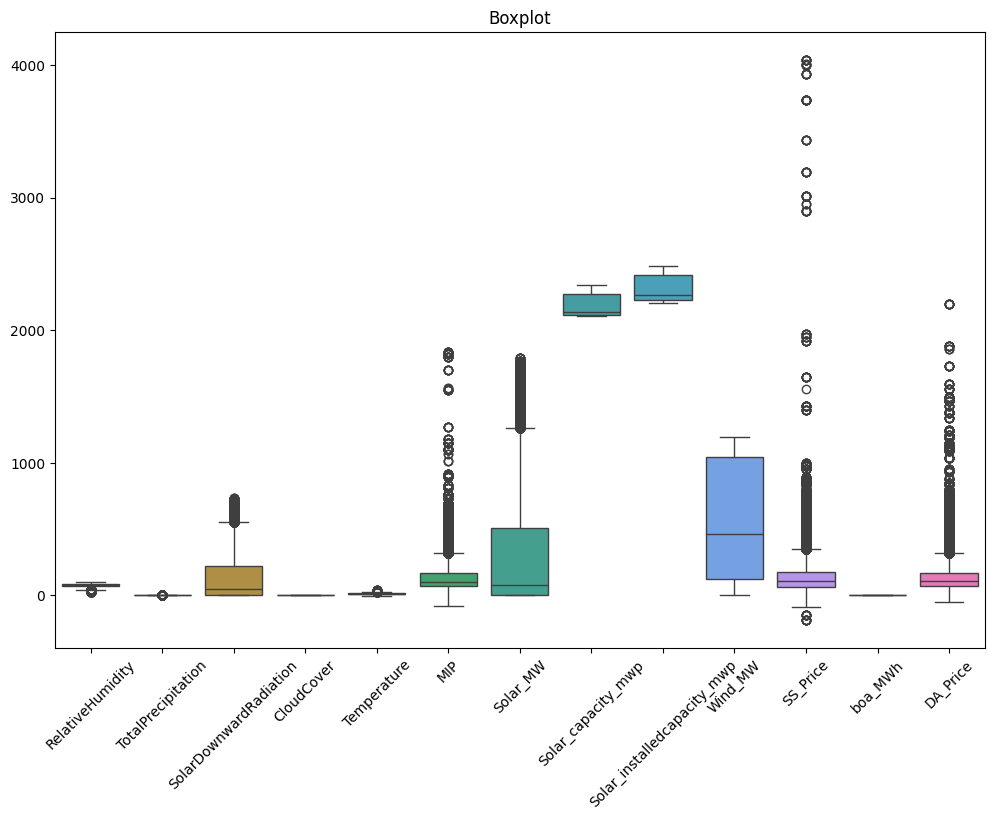

In [18]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=dataRaw.select_dtypes(include=np.number))
plt.title('Boxplot')
plt.xticks(rotation=45)

plt.show()

We can observe that there are indeed outliers. How we know it ? Because we saw that we can consider a data as an outlier if it's value is outside the mean + or - 3 times the standard deviation. And here there are visualize with the points outside the maximum or the minimum.

# Standarisation et Normalisation des features numériques

In [19]:
threshold = 3
scores = np.abs(stats.zscore(dataRaw.select_dtypes(include=np.number)))
outlierRows = np.any(scores > threshold, axis=1)

In [20]:
dataCleaned = dataRaw[~outlierRows]
dataCleaned

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.000000,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.000000,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.000000,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.000000,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
5,2020-09-20 00:00:00+00:00,2020-09-20 05:00:00+00:00,93.136665,0.000000,1.560938,0.702958,14.118970,2020-09-20 05:00:00+00:00,35.89,0.000000,2108.489754,2206.064655,990.988,28.62,0.0,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414953,2023-10-27 00:00:00+00:00,2023-10-27 15:00:00+00:00,82.975662,0.005580,54.687985,0.997149,12.762812,2023-10-27 15:00:00+00:00,NaN,273.082467,2331.383994,2487.180474,279.924,137.80,0.0,122.08
414954,2023-10-27 00:00:00+00:00,2023-10-27 16:00:00+00:00,86.128784,0.002790,6.614947,0.994622,12.048187,2023-10-27 16:00:00+00:00,NaN,31.031948,2331.383994,2487.180474,393.864,140.00,0.0,131.08
414956,2023-10-27 00:00:00+00:00,2023-10-27 18:00:00+00:00,92.317924,0.001674,0.004053,0.828503,10.338953,2023-10-27 18:00:00+00:00,NaN,0.000000,2331.383994,2487.180474,502.142,137.80,0.0,102.10
414959,2023-10-27 00:00:00+00:00,2023-10-27 21:00:00+00:00,95.294044,0.000000,0.005059,0.514824,8.872187,2023-10-27 21:00:00+00:00,NaN,0.000000,2331.383994,2487.180474,364.382,129.00,0.0,82.47


In [21]:
dataCleaned = dataCleaned.copy()
dataCleaned['dtm'] = pd.to_datetime(dataCleaned['dtm'],utc=True)
dataCleaned['year'] = dataCleaned['dtm'].dt.year
dataCleaned['month'] = dataCleaned['dtm'].dt.month
dataCleaned['day'] = dataCleaned['dtm'].dt.day
dataCleaned['hour'] = dataCleaned['dtm'].dt.hour
dataCleaned['minute'] = dataCleaned['dtm'].dt.minute
dataCleaned['second'] = dataCleaned['dtm'].dt.second

timeFeatures = ['dtm','ref_datetime','valid_datetime']
DataNoTime = dataCleaned.drop(timeFeatures, axis=1).copy()



### Imputation of the missing data


There are several NaN data in the dataset.

In [22]:
DataNoTime.isna().sum()

RelativeHumidity                 0
TotalPrecipitation               0
SolarDownwardRadiation           0
CloudCover                       1
Temperature                      0
MIP                            942
Solar_MW                       162
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                          0
SS_Price                         0
boa_MWh                          0
DA_Price                         0
year                             0
month                            0
day                              0
hour                             0
minute                           0
second                           0
dtype: int64

In [23]:
NombreNA = DataNoTime.isna().sum().sum()
row,col = DataNoTime.shape[0],DataNoTime.shape[1]
PourcentageNA = NombreNA*100/(row*col)
PourcentageNA


0.035793218205499716

The amount of missing data seems quite low (3% < 5% of the total of the data from dataset).
It may be not interesting to impute them.
We wanted to experiment an Imputer especially the KNN Imputer which will allow to associate the missing data to a group with similiar values.
And not by imputating by the mean value which will create a distorsion on the values of the dataset

In [24]:
dataImputed = imputationKNN(DataNoTime)

In [25]:
dataImputed.isna().sum()

RelativeHumidity               0
TotalPrecipitation             0
SolarDownwardRadiation         0
CloudCover                     0
Temperature                    0
MIP                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
Wind_MW                        0
SS_Price                       0
boa_MWh                        0
DA_Price                       0
year                           0
month                          0
day                            0
hour                           0
minute                         0
second                         0
dtype: int64

In [26]:
dataImputed

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.000000,2108.489754,2206.064655,941.044,47.95,0.0,32.00,2020.0,9.0,20.0,1.0,0.0,0.0
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.000000,2108.489754,2206.064655,918.432,28.95,0.0,31.99,2020.0,9.0,20.0,2.0,0.0,0.0
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.000000,2108.489754,2206.064655,978.682,30.90,0.0,32.54,2020.0,9.0,20.0,3.0,0.0,0.0
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.000000,2108.489754,2206.064655,1002.902,29.00,0.0,32.28,2020.0,9.0,20.0,4.0,0.0,0.0
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.000000,2108.489754,2206.064655,990.988,28.62,0.0,32.79,2020.0,9.0,20.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,82.975662,0.005580,54.687985,0.997149,12.762812,105.60,273.082467,2331.383994,2487.180474,279.924,137.80,0.0,122.08,2023.0,10.0,27.0,15.0,0.0,0.0
162479,86.128784,0.002790,6.614947,0.994622,12.048187,140.48,31.031948,2331.383994,2487.180474,393.864,140.00,0.0,131.08,2023.0,10.0,27.0,16.0,0.0,0.0
162480,92.317924,0.001674,0.004053,0.828503,10.338953,109.73,0.000000,2331.383994,2487.180474,502.142,137.80,0.0,102.10,2023.0,10.0,27.0,18.0,0.0,0.0
162481,95.294044,0.000000,0.005059,0.514824,8.872187,103.55,0.000000,2331.383994,2487.180474,364.382,129.00,0.0,82.47,2023.0,10.0,27.0,21.0,0.0,0.0


## Data Observation


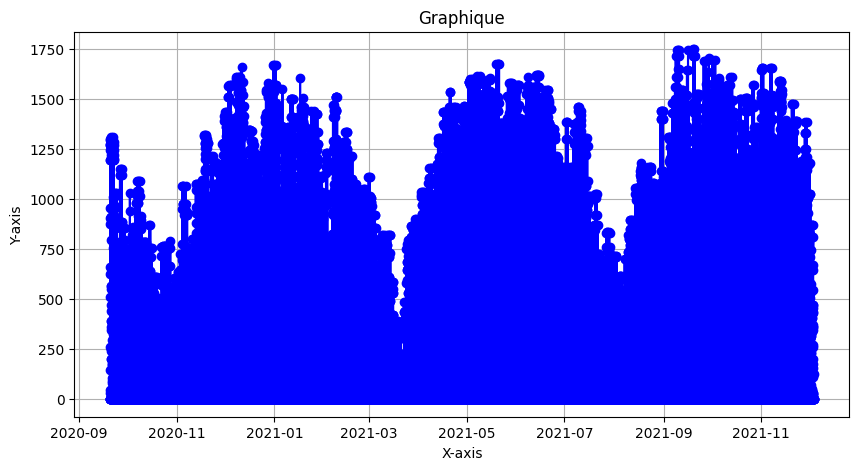

In [27]:
def plot_data2D(df, x_col, y_col, title="Graphique", x_label="X-axis", y_label="Y-axis", grid=True, line_style='-', marker_style='o', color='b'):
    plt.figure(figsize=(10, 5))
    plt.plot(df[x_col], df[y_col], linestyle=line_style, marker=marker_style, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if grid:
        plt.grid(True)
    plt.show()

dataImputed2 = pd.concat([dataImputed, dataCleaned['dtm']], axis=1)
dataImputed2 = dataImputed2.dropna(subset=['dtm'])

plot_data2D(dataImputed2, 'dtm', 'Solar_MW')


Text(0, 0.5, 'Generation [MW]')

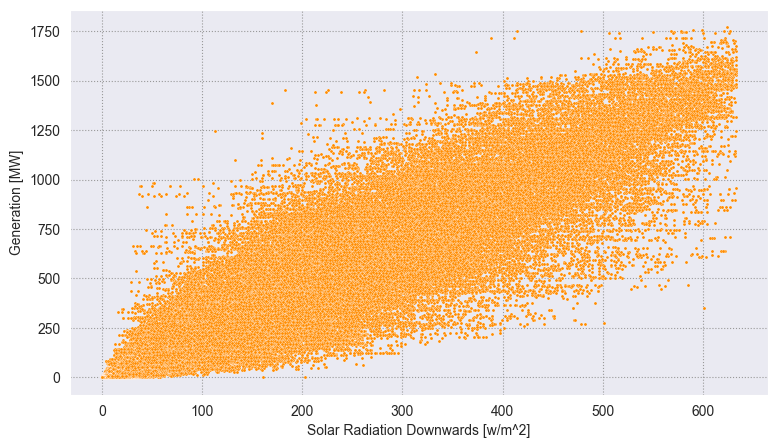

In [28]:
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=dataCleaned, x="SolarDownwardRadiation", 
                y="Solar_MW", color='darkorange',s=5)
plt.xlabel('Solar Radiation Downwards [w/m^2]')
plt.ylabel('Generation [MW]')

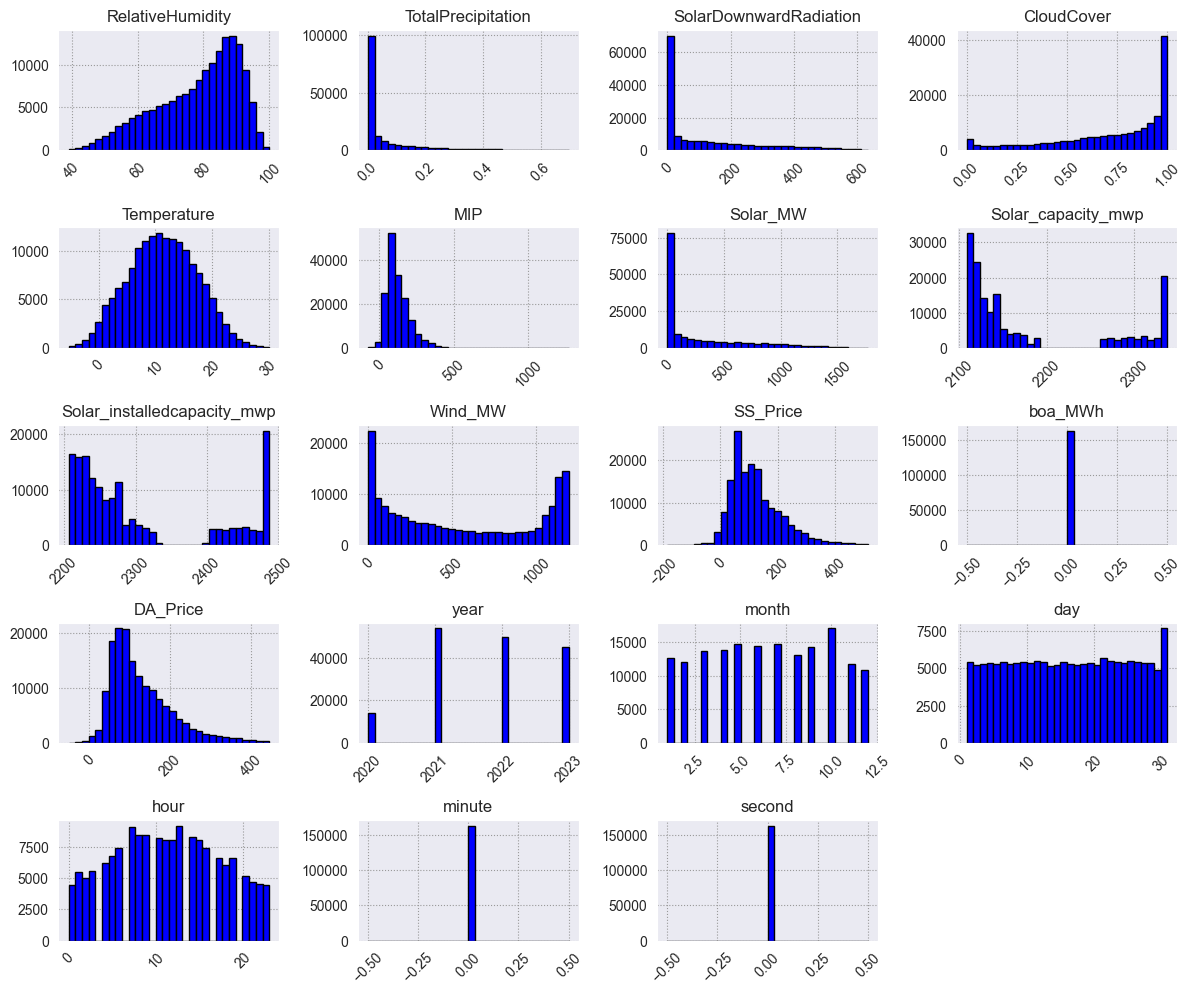

In [29]:
cols_to_plot = [col for col in dataImputed.columns]

plt.figure(figsize=(12, 10))

# we iterate for each columns
for i, col in enumerate(cols_to_plot):
    plt.subplot(5, 4, i + 1)
    plt.hist(dataImputed[col].dropna(), bins=30, color='blue', edgecolor='black')
    plt.title(col)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## Feature Engineering and Preprocessing
We can observe that the distribution of some features are left and right skewed which can be troublesome to deal with.

Left Skewed : 
- TotalPrecipitation 
- SolarDownwardRadiation
- MIP
- Solar_capacity_mwp
- SS_Price 
- DA_Price

Right Skewed : 
- RelativeHumidity
- CloudCover

In order to correct this, we will apply a logarithmic function to positive features and cube root function to other.

In [30]:
dataImputed['log_TotalPrecipitation'] = np.log(dataImputed['TotalPrecipitation'])
dataImputed['log_SolarDownwardRadiation'] = np.log(dataImputed['SolarDownwardRadiation'])
dataImputed['cube_root_MIP'] = np.cbrt(dataImputed['MIP'])
dataImputed['log_Solar_capacity_mwp'] = np.log(dataImputed['Solar_capacity_mwp'])
dataImputed['cube_root_SS_Price'] = np.cbrt(dataImputed['SS_Price'])
dataImputed['cube_root_DA_Price'] = np.cbrt(dataImputed['DA_Price'])

dataImputed['log_RelativeHumidity'] = np.log(dataImputed['RelativeHumidity'])
dataImputed['log_CloudCover'] = np.log(dataImputed['CloudCover'])
dataImputed

c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_TotalPrecipitation,log_SolarDownwardRadiation,cube_root_MIP,log_Solar_capacity_mwp,cube_root_SS_Price,cube_root_DA_Price,log_RelativeHumidity,log_CloudCover
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.000000,2108.489754,2206.064655,941.044,...,0.0,0.0,-inf,-inf,3.060975,7.653727,3.632979,3.174802,4.521506,-0.705184
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.000000,2108.489754,2206.064655,918.432,...,0.0,0.0,-inf,-inf,3.043442,7.653727,3.070550,3.174471,4.527654,-0.604385
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.000000,2108.489754,2206.064655,978.682,...,0.0,0.0,-inf,-inf,3.054557,7.653727,3.137999,3.192561,4.539068,-0.466695
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.000000,2108.489754,2206.064655,1002.902,...,0.0,0.0,-inf,-inf,2.884499,7.653727,3.072317,3.184035,4.544210,-0.384103
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.000000,2108.489754,2206.064655,990.988,...,0.0,0.0,-inf,0.445287,3.298561,7.653727,3.058838,3.200716,4.534068,-0.352458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,82.975662,0.005580,54.687985,0.997149,12.762812,105.60,273.082467,2331.383994,2487.180474,279.924,...,0.0,0.0,-5.188503,4.001644,4.726663,7.754217,5.165152,4.960760,4.418547,-0.002855
162479,86.128784,0.002790,6.614947,0.994622,12.048187,140.48,31.031948,2331.383994,2487.180474,393.864,...,0.0,0.0,-5.881650,1.889332,5.198422,7.754217,5.192494,5.079787,4.455844,-0.005392
162480,92.317924,0.001674,0.004053,0.828503,10.338953,109.73,0.000000,2331.383994,2487.180474,502.142,...,0.0,0.0,-6.392475,-5.508175,4.787496,7.754217,5.165152,4.673855,4.525238,-0.188135
162481,95.294044,0.000000,0.005059,0.514824,8.872187,103.55,0.000000,2331.383994,2487.180474,364.382,...,0.0,0.0,-inf,-5.286501,4.695877,7.754217,5.052774,4.352766,4.556967,-0.663930


In [31]:
scalerStand = StandardScaler()
numericCols = dataImputed.select_dtypes(include=np.number).columns
df = dataImputed
df = df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
df[numericCols] = scalerStand.fit_transform(df[numericCols])



In [32]:
df

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_TotalPrecipitation,log_SolarDownwardRadiation,cube_root_MIP,log_Solar_capacity_mwp,cube_root_SS_Price,cube_root_DA_Price,log_RelativeHumidity,log_CloudCover
0,1.103658,-0.546840,-0.796656,-0.825454,0.392109,-1.209842,-0.740502,-0.866757,-1.015572,0.898858,...,0.0,0.0,0.974188,-0.393916,-1.376429,-0.877829,-0.577976,-1.555478,1.014503,-0.272560
1,1.148806,-0.546840,-0.796656,-0.639244,0.412362,-1.216077,-0.740502,-0.866757,-1.015572,0.846784,...,0.0,0.0,0.974188,-0.393916,-1.390867,-0.877829,-0.921238,-1.555789,1.049568,-0.150037
2,1.233362,-0.546840,-0.796656,-0.352564,0.431207,-1.212132,-0.740502,-0.866757,-1.015572,0.985536,...,0.0,0.0,0.974188,-0.393916,-1.381713,-0.877829,-0.880073,-1.538740,1.114665,0.017328
3,1.271774,-0.546840,-0.796656,-0.160675,0.450178,-1.269393,-0.740502,-0.866757,-1.015572,1.041313,...,0.0,0.0,0.974188,-0.393916,-1.521754,-0.877829,-0.920160,-1.546776,1.143994,0.117721
4,1.196201,-0.546840,-0.786998,-0.082852,0.466190,-1.118098,-0.740502,-0.866757,-1.015572,1.013876,...,0.0,0.0,0.974188,-0.293223,-1.180779,-0.877829,-0.928386,-1.531054,1.086148,0.156185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,0.387419,-0.503413,-0.458296,0.962743,0.242000,-0.231071,-0.050276,1.779347,1.802903,-0.623662,...,0.0,0.0,-0.779280,0.510976,-0.004754,1.770201,0.357141,0.127769,0.427295,0.581135
162479,0.638397,-0.525126,-0.755729,0.953761,0.123863,0.212761,-0.662067,1.779347,1.802903,-0.361265,...,0.0,0.0,-1.013531,0.033319,0.383734,1.770201,0.373829,0.239951,0.640009,0.578051
162480,1.131032,-0.533812,-0.796631,0.363351,-0.158695,-0.178518,-0.740502,1.779347,1.802903,-0.111907,...,0.0,0.0,-1.186165,-1.639479,0.045342,1.770201,0.357141,-0.142635,1.035789,0.355924
162481,1.367922,-0.546840,-0.796625,-0.751505,-0.401170,-0.257156,-0.740502,1.779347,1.802903,-0.429160,...,0.0,0.0,0.974188,-1.589351,-0.030106,1.770201,0.288555,-0.445258,1.216750,-0.222414


Creating some features that are combination of others and that can appear interesting

In [33]:
df['Solar_capacity_x_month'] = df['Solar_capacity_mwp'] * df['month']
df['Solar_capacity_x_hour'] = df['Solar_capacity_mwp'] * df['hour']

In [34]:
df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df['is_spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
df['is_autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)
df['temp_squared'] = df['Temperature'] ** 2
df['radiation_x_cloudcover'] = df['SolarDownwardRadiation'] * df['CloudCover']

In [35]:
correlationMatrix = df.corr()
correlationMatrix

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_CloudCover,Solar_capacity_x_month,Solar_capacity_x_hour,is_summer,is_winter,is_spring,is_autumn,temp_squared,radiation_x_cloudcover
RelativeHumidity,1.000000,0.156499,-0.621767,0.128355,-0.467613,-0.033667,-0.613584,-0.057417,-0.063467,0.081103,...,0.995093,0.076115,-0.083089,-0.029149,NaN,NaN,NaN,NaN,-0.163491,0.040826
TotalPrecipitation,0.156499,1.000000,-0.074596,0.333134,0.065620,-0.076435,-0.055852,0.016271,0.012565,0.169430,...,0.161064,0.225488,0.002497,0.016926,NaN,NaN,NaN,NaN,-0.096305,-0.057129
SolarDownwardRadiation,-0.621767,-0.074596,1.000000,-0.082501,0.453638,-0.028148,0.936270,0.094222,0.098130,-0.178194,...,-0.618911,-0.029776,0.072287,-0.000732,NaN,NaN,NaN,NaN,0.152467,-0.221267
CloudCover,0.128355,0.333134,-0.082501,1.000000,0.115959,-0.068297,-0.067393,-0.007830,-0.011680,0.106267,...,0.129450,0.816629,-0.040905,-0.007251,NaN,NaN,NaN,NaN,-0.152294,-0.086262
Temperature,-0.467613,0.065620,0.453638,0.115959,1.000000,0.026192,0.415248,0.189758,0.203705,-0.162251,...,-0.461029,0.090885,0.090825,0.017083,NaN,NaN,NaN,NaN,0.028394,-0.092589
MIP,-0.033667,-0.076435,-0.028148,-0.068297,0.026192,1.000000,-0.037918,-0.130722,-0.085121,-0.130392,...,-0.036639,-0.058244,-0.075441,-0.004512,NaN,NaN,NaN,NaN,0.173015,0.040851
Solar_MW,-0.613584,-0.055852,0.936270,-0.067393,0.415248,-0.037918,1.000000,0.097643,0.101834,-0.130534,...,-0.609026,-0.023159,0.068566,0.003149,NaN,NaN,NaN,NaN,0.150008,-0.214875
Solar_capacity_mwp,-0.057417,0.016271,0.094222,-0.007830,0.189758,-0.130722,0.097643,1.000000,0.997465,-0.059388,...,-0.052468,-0.003509,-0.026317,0.004976,NaN,NaN,NaN,NaN,0.030873,0.001479
Solar_installedcapacity_mwp,-0.063467,0.012565,0.098130,-0.011680,0.203705,-0.085121,0.101834,0.997465,1.000000,-0.058622,...,-0.058653,-0.006831,-0.016482,0.005030,NaN,NaN,NaN,NaN,0.032269,0.003185
Wind_MW,0.081103,0.169430,-0.178194,0.106267,-0.162251,-0.130392,-0.130534,-0.059388,-0.058622,1.000000,...,0.095934,0.081919,-0.055427,-0.008997,NaN,NaN,NaN,NaN,-0.151678,-0.021986


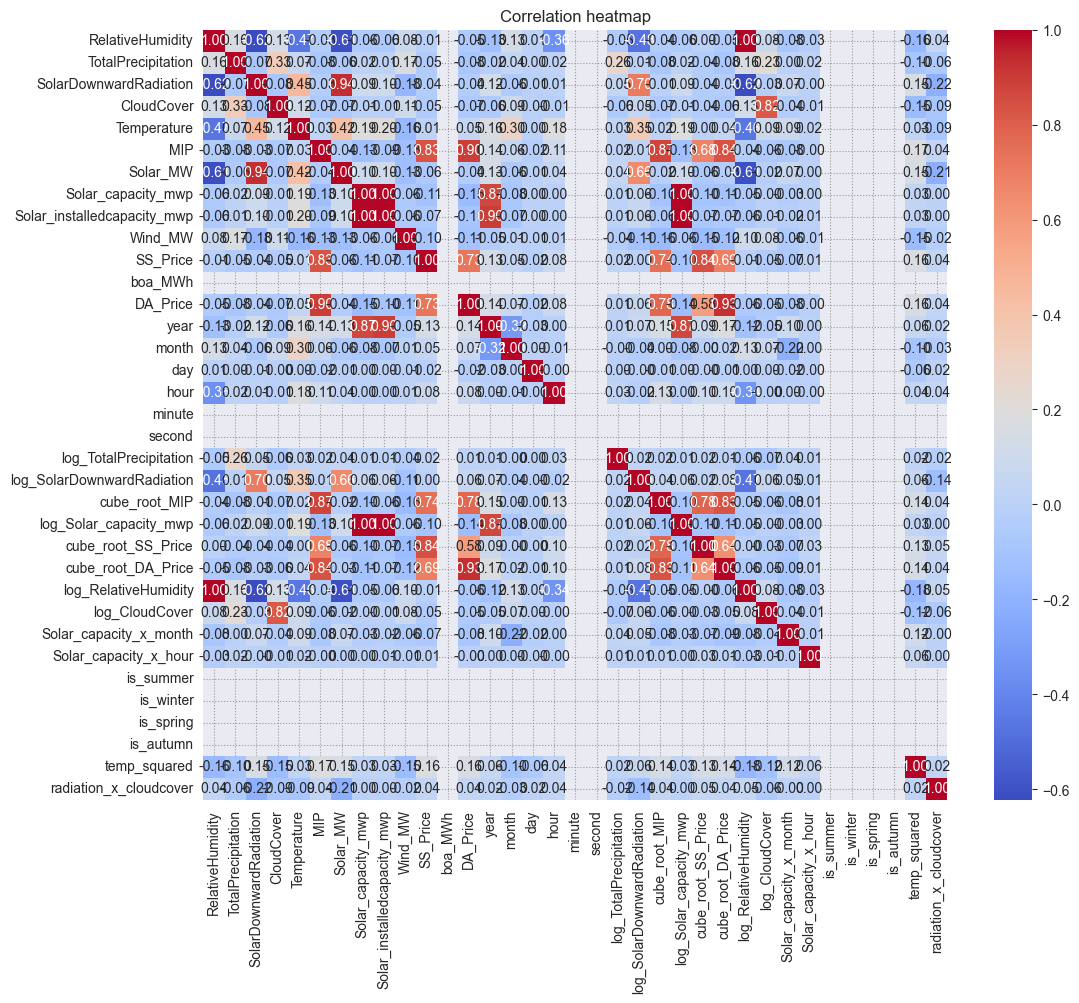

In [36]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap')
plt.show()

In [37]:
features = df.drop(['Solar_MW'], axis = 1)
target = df['Solar_MW']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

selector = SelectKBest(f_regression, k=10)
selector.fit(features, target)

X_trainSelected = selector.fit_transform(X_train, y_train)
X_testSelected = selector.transform(X_test)

selectedFeaturesInter = features.columns[selector.get_support()]
print("Selected features :", selectedFeaturesInter)

selectedIndices = selector.get_support(indices=True)

selectedFeatures = features.columns[selectedIndices]

dfFinal = pd.DataFrame({'Features': selectedFeatures,
                        'Score': selector.scores_[selectedIndices],
                        'P-value': selector.pvalues_[selectedIndices]})

dfFinal.sort_values(by='P-value', inplace=True)

print(dfFinal)

Selected features : Index(['RelativeHumidity', 'SolarDownwardRadiation', 'Temperature',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'year',
       'log_SolarDownwardRadiation', 'log_RelativeHumidity', 'temp_squared',
       'radiation_x_cloudcover'],
      dtype='object')
                      Features          Score        P-value
0             RelativeHumidity   78647.891767   0.000000e+00
1       SolarDownwardRadiation  927435.814864   0.000000e+00
2                  Temperature   27020.873627   0.000000e+00
4                      Wind_MW    2220.658542   0.000000e+00
5                         year    2201.509946   0.000000e+00
6   log_SolarDownwardRadiation   97906.831461   0.000000e+00
7         log_RelativeHumidity   76829.441529   0.000000e+00
8                 temp_squared    2968.345977   0.000000e+00
9       radiation_x_cloudcover    6388.704334   0.000000e+00
3  Solar_installedcapacity_mwp    1401.672198  3.897205e-305


Evaluating the model's performance using Mean Squared Error (MSE) and R² Score
MSE measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value
R² Score provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model

In [43]:
model = LinearRegression()
model.fit(X_trainSelected, y_train)

y_pred = model.predict(X_testSelected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MSE score:", mse)
print("R² Score:", r2)
print("Root Mean Squared Error (RMSE) :", rmse)
print("Mean Absolute Percentage Error (MAPE) :", mape)

MSE score: 0.12184744743155364
R² Score: 0.8782753534061288
Root Mean Squared Error (RMSE) : 0.34906653725551184
Mean Absolute Percentage Error (MAPE) : 1.217045995181225


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
dtModel = DecisionTreeRegressor(random_state=23)
dtModel.fit(X_trainSelected, y_train)
dtPred = dtModel.predict(X_testSelected)
dtMse = mean_squared_error(y_test, dtPred)
dtR2 = r2_score(y_test, dtPred)
print("Decision Tree - MSE:", dtMse, "and R^2:", dtR2)

dtRmse = mean_squared_error(y_test, dtPred,squared=False)
dtMape = mean_absolute_percentage_error(y_test, dtPred)

print("Decision Tree - Root Mean Squared Error (RMSE) :", dtRmse)
print("Decision Tree - Mean Absolute Percentage Error (MAPE) :", dtMape)

Decision Tree - MSE: 0.07502462005183858 and R^2: 0.9250509915952116
Decision Tree - Root Mean Squared Error (RMSE) : 0.273906224923492
Decision Tree - Mean Absolute Percentage Error (MAPE) : 0.8066980936307516


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
rfModel = RandomForestRegressor(random_state=23)
rfModel.fit(X_trainSelected, y_train)
rfPred = rfModel.predict(X_testSelected)
rfMse = mean_squared_error(y_test, rfPred)
rfR2 = r2_score(y_test, rfPred)
print("Random Forest - MSE:", rfMse, "and R^2:", rfR2)
rfMse = mean_squared_error(y_test, rfPred,squared=False)
rfMape = mean_absolute_percentage_error(y_test, rfPred)

print("Random Forest - Root Mean Squared Error (RMSE) :", rfMse)
print("Random Forest - Mean Absolute Percentage Error (MAPE) :", rfMape)

Random Forest - MSE: 0.03897656119728173 and R^2: 0.9610627203343868
Random Forest - Root Mean Squared Error (RMSE) : 0.19742482416677426
Random Forest - Mean Absolute Percentage Error (MAPE) : 0.6526031165053061


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Globally, the random forest is better even though its computation time is significantly higher. We will proceed to apply a grid search cross validation to optimize its hyper parameters.

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split

rfModel = RandomForestRegressor(random_state=42)

paramGrid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gridSearch = GridSearchCV(estimator=rfModel, param_grid=paramGrid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gridSearch.fit(X_trainSelected, y_train)

bestParams = gridSearch.best_params_
print("Best parameters found: ", bestParams)

bestRfModel = gridSearch.best_estimator_
bestRfModel.fit(X_trainSelected, y_train)

bestRfPred = bestRfModel.predict(X_testSelected)

bestRfMse = mean_squared_error(y_test, bestRfPred)
bestRfR2 = r2_score(y_test, bestRfPred)
bestRfMse = mean_squared_error(y_test, bestRfPred, squared=False)
bestRfMape = mean_absolute_percentage_error(y_test, bestRfPred)

print("Random Forest - MSE:", bestRfMse, "and R^2:", bestRfR2)
print("Random Forest - Root Mean Squared Error (RMSE):", bestRfMse)
print("Random Forest - Mean Absolute Percentage Error (MAPE):",bestRfMape)


Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - MSE: 0.19504646864249842 and R^2: 0.961995215861859
Random Forest - Root Mean Squared Error (RMSE): 0.19504646864249842
Random Forest - Mean Absolute Percentage Error (MAPE): 0.6426331135890242


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
import pickle
model_filename = 'best_rf_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(bestRfModel, file)

print(f"Model saved to {model_filename}")
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Utiliser le modèle chargé pour faire des prédictions
loaded_rf_preds = loaded_model.predict(X_testSelected)

# Calculer les métriques de performance pour vérifier que le modèle a été correctement chargé
loaded_rf_mse = mean_squared_error(y_test, loaded_rf_preds)
loaded_rf_r2 = r2_score(y_test, loaded_rf_preds)
loaded_rmse = mean_squared_error(y_test, loaded_rf_preds, squared=False)
loaded_mape = mean_absolute_percentage_error(y_test, loaded_rf_preds)

print("Loaded Random Forest - MSE:", loaded_rf_mse, "and R^2:", loaded_rf_r2)
print("Loaded Root Mean Squared Error (RMSE):", loaded_rmse)
print("Loaded Mean Absolute Percentage Error (MAPE):", loaded_mape)

Model saved to best_rf_model.pkl
Loaded Random Forest - MSE: 0.03804312492990911 and R^2: 0.961995215861859
Loaded Root Mean Squared Error (RMSE): 0.19504646864249842
Loaded Mean Absolute Percentage Error (MAPE): 0.6426331135890242


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##Partie prédiction

In [250]:
dataPD2024 = pd.read_csv("Energy_Data_20200920_20240118.csv")
dataNC2024_1 = xr.open_dataset("dwd_icon_eu_pes10_20240108_20240129.nc")
dataNC2024_2 = xr.open_dataset("dwd_icon_eu_pes10_20231027_20240108.nc")

In [251]:
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'], utc=True)
dataPD2024

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20 00:00:00+00:00,20.06,0.0,2130.537493,2228.208777,996.284,2.50000,0.0,32.17
1,2020-09-20 00:30:00+00:00,19.77,0.0,2130.537493,2228.208777,957.576,15.00000,0.0,32.17
2,2020-09-20 01:00:00+00:00,28.68,0.0,2130.537493,2228.208777,941.044,47.95000,0.0,32.00
3,2020-09-20 01:30:00+00:00,28.97,0.0,2130.537493,2228.208777,964.366,29.13000,0.0,32.00
4,2020-09-20 02:00:00+00:00,28.19,0.0,2130.537493,2228.208777,918.432,28.95000,0.0,31.99
...,...,...,...,...,...,...,...,...,...
58363,2024-01-18 21:30:00+00:00,71.24,0.0,2448.407255,2609.200511,1154.560,57.49165,0.0,64.75
58364,2024-01-18 22:00:00+00:00,70.15,0.0,2448.407255,2609.200511,1141.020,46.14432,0.0,65.88
58365,2024-01-18 22:30:00+00:00,68.36,0.0,2448.407255,2609.200511,1167.660,50.00000,0.0,65.88
58366,2024-01-18 23:00:00+00:00,68.77,0.0,2448.407255,2609.200511,1121.160,35.00000,0.0,64.74


In [252]:
dataNC2024_1

<xarray.Dataset>
Dimensions:                 (reference_time: 85, valid_time: 93, point: 20)
Coordinates:
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * reference_time          (reference_time) datetime64[ns] 2024-01-08 ... 20...
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 ...
    Temperature             (reference_time, valid_time, point) float32 ...

In [253]:
dataNC2024_2

<xarray.Dataset>
Dimensions:                 (valid_time: 93, reference_time: 293, point: 20)
Coordinates:
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * reference_time          (reference_time) datetime64[ns] 2023-10-27 ... 20...
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 ...
    Temperature             (reference_time, valid_time, point) float32 ...

In [254]:
dataNC2024 = xr.merge([dataNC2024_1, dataNC2024_2], join='outer')
dataNC2024

<xarray.Dataset>
Dimensions:                 (point: 20, reference_time: 377, valid_time: 93)
Coordinates:
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * reference_time          (reference_time) datetime64[ns] 2023-10-27 ... 20...
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
    latitude                (point) float64 52.49 52.88 52.14 ... 52.88 52.08
    longitude               (point) float64 0.4012 0.7907 ... 1.192 -0.01135
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 0.659...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 0.0 ....
    Temperature             (reference_time, valid_time, point) float32 8.36 ...

In [255]:
dataNC2024 = dataNC2024.rename({'reference_time': 'ref_datetime'})
dataNC2024 = dataNC2024.rename({'valid_time': 'valid_datetime'})
dataNC2024

<xarray.Dataset>
Dimensions:                 (point: 20, ref_datetime: 377, valid_datetime: 93)
Coordinates:
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * ref_datetime            (ref_datetime) datetime64[ns] 2023-10-27 ... 2024...
  * valid_datetime          (valid_datetime) int64 0 1 2 3 4 ... 111 114 117 120
    latitude                (point) float64 52.49 52.88 52.14 ... 52.88 52.08
    longitude               (point) float64 0.4012 0.7907 ... 1.192 -0.01135
Data variables:
    CloudCover              (ref_datetime, valid_datetime, point) float32 0.6...
    SolarDownwardRadiation  (ref_datetime, valid_datetime, point) float64 0.0...
    Temperature             (ref_datetime, valid_datetime, point) float32 8.3...

In [256]:
ds_sorted = dataNC2024.sortby('ref_datetime')
# Convertir le timestamp en numpy.datetime64

date_limite = np.datetime64('2024-01-18')
date_début = np.datetime64('2023-10-28')

# Sélectionnez les données jusqu'à la date limite inclusive
dataNC2024 = ds_sorted.sel(ref_datetime=slice(date_début, date_limite )) 
dataNC2024

<xarray.Dataset>
Dimensions:                 (point: 20, ref_datetime: 329, valid_datetime: 93)
Coordinates:
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * ref_datetime            (ref_datetime) datetime64[ns] 2023-10-28 ... 2024...
  * valid_datetime          (valid_datetime) int64 0 1 2 3 4 ... 111 114 117 120
    latitude                (point) float64 52.49 52.88 52.14 ... 52.88 52.08
    longitude               (point) float64 0.4012 0.7907 ... 1.192 -0.01135
Data variables:
    CloudCover              (ref_datetime, valid_datetime, point) float32 0.8...
    SolarDownwardRadiation  (ref_datetime, valid_datetime, point) float64 0.0...
    Temperature             (ref_datetime, valid_datetime, point) float32 7.9...

In [257]:
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'])

# Définir les dates de début et de fin
date_début = pd.Timestamp('2023-10-28', tz='UTC')
date_limite = pd.Timestamp('2024-01-18', tz='UTC')

# Filtrer les données pour inclure uniquement les dates entre date_debut et date_fin
dataPD2024 = dataPD2024[(dataPD2024['dtm'] >= date_début) & (dataPD2024['dtm'] <= date_limite)]

dataPD2024

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
54384,2023-10-28 00:00:00+00:00,102.70,0.0,2453.093454,2609.200511,39.364,133.00,0.0,58.27
54385,2023-10-28 00:30:00+00:00,98.19,0.0,2453.093454,2609.200511,57.204,12.00,0.0,58.27
54386,2023-10-28 01:00:00+00:00,71.73,0.0,2453.093454,2609.200511,72.764,0.00,0.0,51.71
54387,2023-10-28 01:30:00+00:00,68.20,0.0,2453.093454,2609.200511,86.964,0.00,0.0,51.71
54388,2023-10-28 02:00:00+00:00,71.15,0.0,2453.093454,2609.200511,82.282,-5.00,0.0,48.30
...,...,...,...,...,...,...,...,...,...
58316,2024-01-17 22:00:00+00:00,76.48,0.0,2448.464405,2609.200511,318.200,98.90,0.0,65.77
58317,2024-01-17 22:30:00+00:00,71.34,0.0,2448.464405,2609.200511,428.040,98.90,0.0,65.77
58318,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93
58319,2024-01-17 23:30:00+00:00,72.48,0.0,2448.407255,2609.200511,408.820,58.00,0.0,66.93


In [258]:
derniereDateNC = dataNC2024['ref_datetime'].max().values
derniereDateNC

numpy.datetime64('2024-01-18T00:00:00.000000000')

In [259]:

derniereDatePD = dataPD2024["dtm"].max()
derniereDatePD

Timestamp('2024-01-18 00:00:00+0000', tz='UTC')

In [260]:
premiereeDateNC = dataNC2024['ref_datetime'].min().values
premiereeDateNC

numpy.datetime64('2023-10-28T00:00:00.000000000')

In [261]:
premiereeDatePD = dataPD2024["dtm"].min()
premiereeDatePD

Timestamp('2023-10-28 00:00:00+0000', tz='UTC')

La case en dessous cest pas vraiment le train set non ?? Le train set/ test set cest les datasets quon a fait plus haut qui va du 20 sept 2020 au 27 octobre 2023 et celui la quon vient dimporter cest pour predire/évaluer (28 octobre 2023 au 18 janvier 2024)

In [268]:
trainingSet = dfPropre(dataPD2024,dataNC2024)

/var/folders/cf/pfmwqlv90tscsb37tqjz90qh0000gn/T/ipykernel_21955/2447086840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)
/var/folders/cf/pfmwqlv90tscsb37tqjz90qh0000gn/T/ipykernel_21955/2447086840.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataRaw['year'] = dataRaw['dtm'].dt.year
/var/folders/cf/pfmwqlv90tscsb37tqjz90qh0000gn/T/ipykernel_21955/2447086840.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [269]:
trainingSet

,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second,dtm


In [ ]:
trainingSet = trainingSet.drop()

In [97]:
"""
Part : Prediction with Linear Regression
"""

'\nPart : Prediction with Linear Regression\n'

In [107]:

Accuracies = []
model = LinearRegression()
X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred=np.round(y_pred)
accuracy = (y_test==y_pred).mean()
Accuracies.append(accuracy)
pd.Series(Accuracies).describe()

count    1.000000
mean     0.008241
std           NaN
min      0.008241
25%      0.008241
50%      0.008241
75%      0.008241
max      0.008241
dtype: float64

In [85]:
"""
Part : Prediction with Random Forest
"""

'\nPart : Prediction with Random Forest\n'

In [109]:

X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
y_pred = np.round(model.predict(X))
MSE = np.sum((y_pred-y)**2)/y.shape[0]
MSE

0.0004926549623790755

In [ ]:
"""
Part : Prediction with Neural Networks
"""

In [89]:
#Prend beaucoup de temps

model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,5), random_state=0)
Accuracies = []
X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
y_pred = np.round(model.predict(X_test))
accuracy = (y_test==y_pred).mean()
Accuracies.append(accuracy)
pd.Series(Accuracies).describe()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning:

Training interrupted by user.



count    1.000000
mean     0.565546
std           NaN
min      0.565546
25%      0.565546
50%      0.565546
75%      0.565546
max      0.565546
dtype: float64

In [ ]:
"""
Part : Prediction with ...
"""

In [ ]:
"""
Part : Best Model 
"""

In [41]:
"""
Part : DashBoard
"""

'\nPart : DashBoard\n'

In [88]:


# Initialisation de l'application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.Div(children='Régression Linéaire avec Dash'),
    html.Button('Lancer la prédiction', id='predict-button'),
    dcc.Graph(id='prediction-graph'),
])

# Assumons que data_final et data_final2 sont vos DataFrames prédéfinis

dataImputed2 = pd.DataFrame({
    'dtm': pd.date_range(start='2021-05-01', periods=50, freq='D'),
    'Solar_MW': np.random.rand(50) * 100
})

# Callback pour mettre à jour le graphique avec les prédictions
@app.callback(
    Output('prediction-graph', 'figure'),
    Input('predict-button', 'n_clicks')
)
def update_graph(n_clicks):
    if n_clicks is None:
        # Ne rien afficher avant que le bouton soit cliqué
        return go.Figure()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Création du graphique de prédiction
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataImputed2['dtm'], y=y_pred, mode='markers', name='Données réelles'))
    fig.add_trace(go.Scatter(x=dataImputed2['dtm'], y=y_test, mode='markers', name='Données réelles'))
    fig.update_layout(title='Comparaison des Prédictions et des Données Réelles', xaxis_title='Date', yaxis_title='Solar MW')

    return fig

# Exécuter l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)  # Utilisez un numéro de port différent si nécessaire


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

